## SETUP

In [1]:
#-----------------#
#                 # 
#  Davis Busteed  #
#  ECON 484       #
#                 #
#-----------------#

In [2]:
#--------------------#
#                    #
#  import libraries  #
#                    #
#--------------------#

# data manipulation library
import pandas as pd

# scikit-learn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# scikit-learn models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# MatPlotLib for making charts
import matplotlib.pyplot as plt

# native modules
from inspect import getfullargspec
from datetime import datetime
from abc import ABCMeta

In [3]:
#-------------------------#
#                         #
#  constants / functions  #
#                         #
#-------------------------#

SEED = 372
CV_FOLDS = 5
USE_TFIDF = False

def get_time():
    return datetime.now().strftime('%H:%M:%S')

In [4]:
#-----------------#
#                 #
#  checkout data  #
#                 #
#-----------------#

# load data
df = pd.read_json('../data/processed_tweets.json')

# checkout the head and shape
print(df.head())
print(df.shape)

   country                                           raw_text  at_count  \
0  ENGLAND               @HauwaTafida I wonder who asked them         1   
1  ENGLAND                                          😩😩cute af         0   
2  ENGLAND  @KateDrummond_ @DIBSRescue I’m SO pleased for ...         2   
3  ENGLAND                      @den2114 Sold her country out         1   
4  ENGLAND                       Why isn’t silence an option?         0   

   hash_count  emoji_count  has_url                      clean_text  text_len  \
0           0            0        0         I wonder who asked them        24   
1           0            2        0                         cute af         7   
2           0            2        0   I’m SO pleased for you guys!         30   
3           0            0        0            Sold her country out        21   
4           0            0        0    Why isn’t silence an option?        28   

   word_count  sentiment  
0           6     0.0000  
1       

In [5]:
#----------------#
#                #
#  prepare data  #
#                #
#----------------#

# y (outcome) vector is the origin country of the tweet
y = df['country']

# X (predictors) matrix is the numeric features, everything but the 'y' and text variables
X = df.drop(columns=['country', 'raw_text', 'clean_text'])

# use default .75 split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=SEED)

In [6]:
#--------------------------#
#                          #
#  define ModelEval class  #
#                          #
#--------------------------#

# this class defines a model, CV grid,
# and a method for training and testing the results
class ModelEvaluator():
    
    # constructor
    def __init__(self, name, model, grid=None, seed=SEED, folds=CV_FOLDS):
        self.name = name
        self.model = model
        self.grid = grid
        self.seed = seed
        self.folds = folds

    # find tuning parameters, return best model
    def find_best_model(self):
        
        print(f'[{get_time()}] * Creating models...')
        
        # it's sometimes necessary to pass in a pre-built model,
        # if 'self.model' is only an Abstract Base Class (ABCMeta)
        # then we need to instatiate the model
        if isinstance(self.model, ABCMeta):
            
            # not all models have a 'random_state' option
            if 'random_state' in getfullargspec(self.model).args:
                mdl = self.model(random_state=self.seed)
            else:
                mdl = self.model()
        
        # when the model was already instatiated
        else:
            mdl = self.model
            
        print(f'[{get_time()}] * Evaluating models...')
            
        # cross-validate to find parameters if a grid was provided
        if self.grid:
            cv = GridSearchCV(mdl, self.grid, cv=self.folds)
            cv.fit(X_train, y_train)
            score = cv.best_estimator_.score(X_test, y_test)
            params = cv.best_params_
            mdl = cv.best_estimator_
        else:
            mdl.fit(X_train, y_train)
            score = mdl.score(X_test, y_test)
            params = 'none'
    
        # return the name, score, parameters,
        # and the actual model object
        return [self.name, score, params, mdl]

## TEST MULTIPLE MODELS w/ ALL FEATURES

In [7]:
#--------------------------#
#                          #
#  define possible models  #
#                          #
#--------------------------#

possible_models = [
    
    # decision tree
    ModelEvaluator(name="Decision Tree",
                   model=DecisionTreeClassifier,
                   grid={'max_depth': [2,3,4,5,7,10], 'min_samples_leaf': [1,3,5,7,10]}
    ),
    
    # bagging
    ModelEvaluator(name="Bagging",
                   model=RandomForestClassifier,
                   grid={'max_depth': [2,3,4,5,7,10], 'min_samples_leaf': [1,3,5,7,10],
                         'n_estimators': [50], 'max_features': [None]}
    ),
    
    # random forest
    ModelEvaluator(name="Random Forest",
                   model=RandomForestClassifier,
                   grid={'max_depth': [2,3,4,5,7,10], 'min_samples_leaf': [1,3,5,7,10],
                         'n_estimators': [50]}
    ),
    
    # boosting
    ModelEvaluator(name="Boosting",
                   model=GradientBoostingClassifier,
                   grid={'learning_rate': [.001, .01, .1, .25, .5, .75, 1], 'n_estimators': [50]}
    ),
    
    # KNN -- left out because it was consistently bad
    ModelEvaluator(name="K-Nearest Neighbors",
                   model=KNeighborsClassifier,
                   grid={'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
    ),
    
    # SVC
    ModelEvaluator(name="Support Vector Classifer",
                   model=SVC,
                   grid={'C': [0.1, .25, .5, 1], 'kernel': ['rbf'], 'gamma': ['auto']}
    ),
    
    # LogReg
    ModelEvaluator(name="Logistic Regression",
                   model=LogisticRegression(solver='lbfgs')
    ),
    
    # NN
    ModelEvaluator(name="Neural Network",
                   model=MLPClassifier,
                   grid={'hidden_layer_sizes': [(100,50,20), (10,10,10,10,10), (200,100,50)], 'max_iter': [200]}
    ),
]

In [8]:
#--------------------------------#
#                                #
#  run all models, save results  #
#                                #
#--------------------------------#

results = []

# loop thru every possible model,
# and use the 'find_best_model' method built-in the class.
# save these results to a list
for i,pm in enumerate(possible_models):
    
    # show the progress of the model evaulation
    print(f'[{get_time()}] Working on {pm.name} models ({i+1} of {len(possible_models)})')
    
    # save the results
    results.append( pm.find_best_model() )
    
print(f'[{get_time()}] All models evaluated')

[10:21:42] Working on Decision Tree models (1 of 8)
[10:21:42] * Creating models...
[10:21:42] * Evaluating models...
[10:22:07] Working on Bagging models (2 of 8)
[10:22:07] * Creating models...
[10:22:07] * Evaluating models...
[10:26:43] Working on Random Forest models (3 of 8)
[10:26:43] * Creating models...
[10:26:43] * Evaluating models...
[10:28:36] Working on Boosting models (4 of 8)
[10:28:36] * Creating models...
[10:28:36] * Evaluating models...
[10:29:14] Working on K-Nearest Neighbors models (5 of 8)
[10:29:14] * Creating models...
[10:29:14] * Evaluating models...
[10:29:49] Working on Support Vector Classifer models (6 of 8)
[10:29:49] * Creating models...
[10:29:49] * Evaluating models...
[10:44:03] Working on Logistic Regression models (7 of 8)
[10:44:03] * Creating models...
[10:44:03] * Evaluating models...
[10:44:03] Working on Neural Network models (8 of 8)
[10:44:03] * Creating models...
[10:44:03] * Evaluating models...


c:\users\buste\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\buste\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\buste\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\buste\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stoch

[10:54:18] All models evaluated


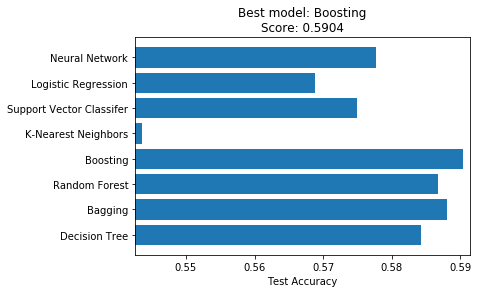

In [9]:
# data for the plot
labels = [r[0] for r in results]
scores = [r[1] for r in results]

# find the best model within the results
# by selecting the model with the highest test accuracy
best_score = max(scores)
best_model = [r for r in results if r[1] == best_score][0]

# plot the labels / scores
plt.barh(labels, scores)
plt.xlim([min(scores)-.001, max(scores)+.001])
plt.title(f'Best model: {best_model[0]}\nScore: {best_score}')
plt.xlabel('Test Accuracy')
plt.show()

In [10]:
# print the details of the best model
print(f'Details for {best_model[0]} (best model):\n')
print(f'Score:\n\t{best_model[1]}\n')
print(f'Non-default params:\n\t{best_model[2]}')

Details for Boosting (best model):

Score:
	0.5904

Non-default params:
	{'learning_rate': 0.5, 'n_estimators': 50}


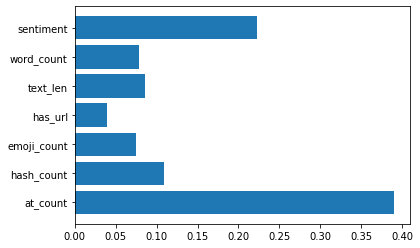

In [11]:
# check out feature importances
plt.barh(X_train.columns, best_model[3].feature_importances_)
plt.show()

In [12]:
#-----------------------------------------#
#                                         #
#  make predictions and confusion matrix  #
#                                         #
#-----------------------------------------#

# make predictions
y_pred = best_model[3].predict(X_test)

# build a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['AMERICA', 'ENGLAND'])

print(cm)

[[2971 2029]
 [2067 2933]]


## REMAKE BEST MODEL USING TF-IDF

In [13]:
#------------------------------------------#
#                                          #
#  create a TF-IDF matrix from clean_text  #
#  try TF-IDF with the best model          #
#                                          #
#------------------------------------------#

# make TfidfVectorizer object
vect = TfidfVectorizer()

# create the TF-IDF matrix
tfidf = pd.DataFrame(vect.fit_transform(df['clean_text']).toarray(), columns=vect.get_feature_names())

In [14]:
# recreate the best model from previous steps
# using same tuning parameters (see a couple cells above 
# where mode details were printed)
mdl = GradientBoostingClassifier(random_state=SEED, n_estimators=50, learning_rate=.5)

# reduce TF-IDF to 100 principal components
pca100 = PCA(n_components=100, random_state=SEED)
tfidf_100 = pca100.fit_transform(tfidf)

# make a new train and test set
X_train, X_test, y_train, y_test = train_test_split(tfidf_100, y, stratify=y, random_state=SEED)

# fit and score the model with just using TF-IDF
mdl.fit(X_train, y_train)
mdl.score(X_test, y_test)

0.5796

In [15]:
# combine features from before (X) and PCA(tfidf)
X_tfidf_100 = X.join(pd.DataFrame(tfidf_100))
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_100, y, stratify=y, random_state=SEED)

# model with extracted features (X) and TF-IDF
mdl.fit(X_train, y_train)
mdl.score(X_test, y_test)

0.6009

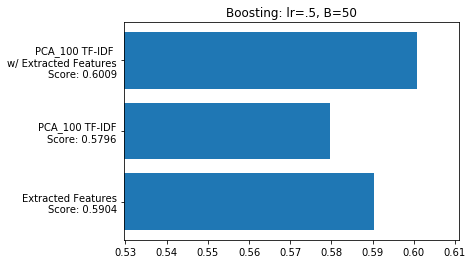

In [16]:
# plot the accuray scores and the model types
# (i just collected the scores manually and added them here)
scores = [0.5904, 0.5796, 0.6009]
plt.barh([f'Extracted Features\nScore: {scores[0]}', f'PCA_100 TF-IDF\nScore: {scores[1]}', f'PCA_100 TF-IDF \nw/ Extracted Features\nScore: {scores[2]}'], scores)
plt.title(f'Boosting: lr=.5, B=50')
plt.xlim([min(scores)-.05, max(scores)+.01])
plt.show()